# Autoregressive Integrated Moving Averages

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Augmented Dickey Fuller Test

In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [4]:
# Load datasets
df1 = pd.read_csv('daily-total-female-births.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months
df1

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-04-26,35
1959-04-27,40
1959-04-28,42


In [5]:
df2 = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'
df2

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


---
# EDA 
---

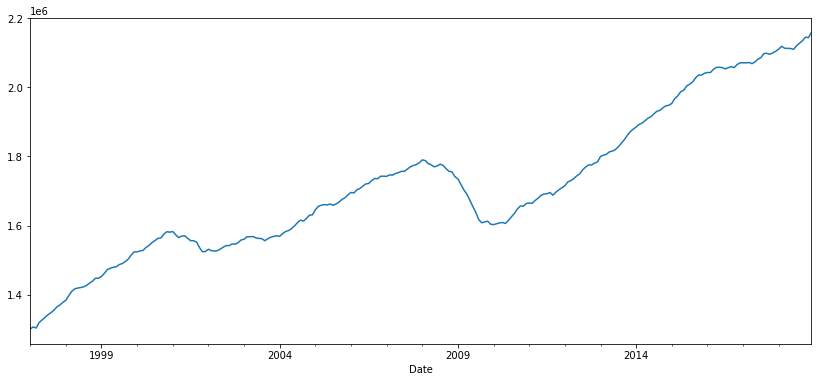

In [6]:
df2['Inventories'].plot(figsize=(14,6))
plt.show()

### Run an ETS Decomposition (optional)

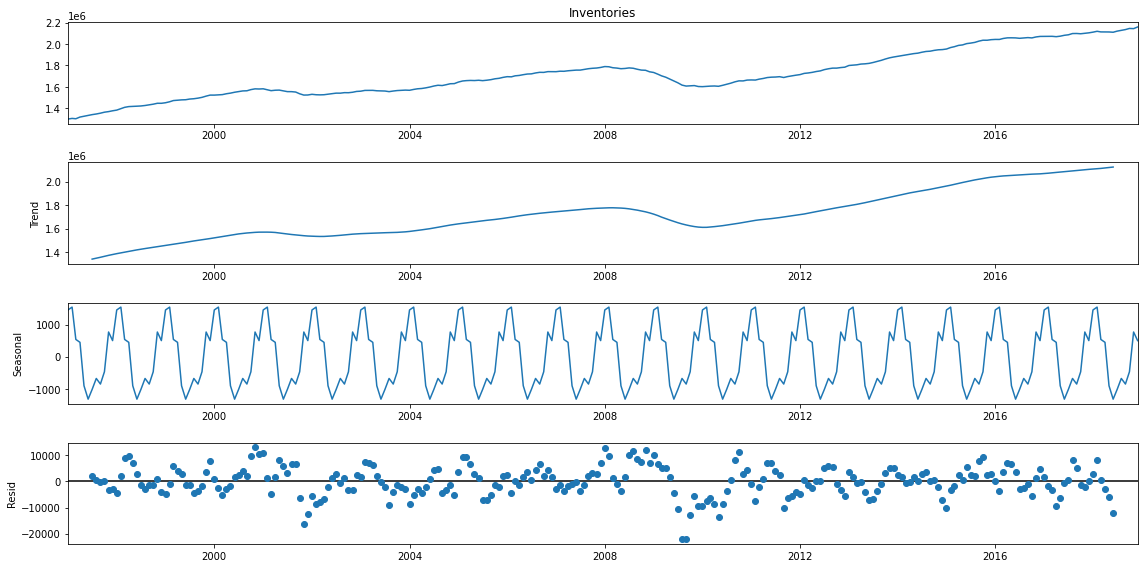

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
    result.plot()

### Check stationarity using Dickey-Fuller Test

In [8]:
adf_test(df2['Inventories'])

Fail to reject the null hypothesis
Data is non-stationary


### Do first order differencing - (optional)

In [9]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)
adf_test(df2['d1'])

Reject the null hypothesis
Data is stationary


In [10]:
len(df2)

264

In [11]:
# Set one year for testing
train_data = df2.Inventories[:200]
test_data = df2.Inventories[200:]

In [12]:
print('Train', train_data.shape)

Train (200,)


<AxesSubplot: xlabel='Date'>

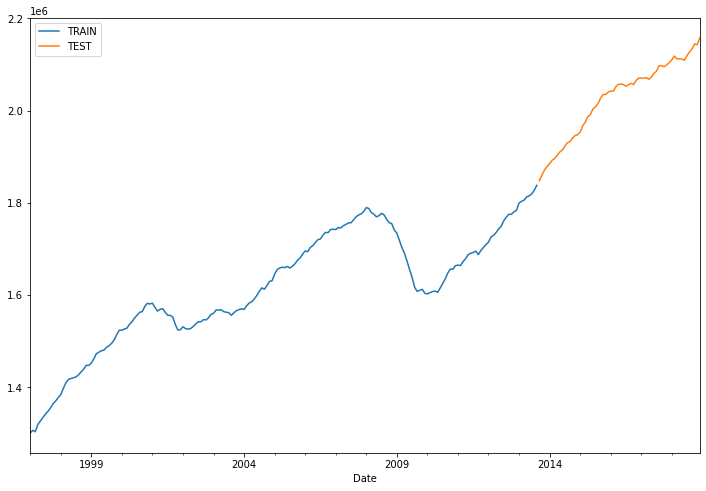

In [13]:
train_data.plot(legend=True,label='TRAIN')
test_data.plot(legend=True,label='TEST',figsize=(12,8))

### ARIMA Hyperparameter Tuning

In [14]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [15]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [16]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(df2.Inventories.values, p_values, d_values, q_values)

name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not defined
name 'train' is not 

### Build Model based on the optimized values

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
model = ARIMA(train_data,order=(3, 0, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  200
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -1987.318
Date:                Mon, 03 Oct 2022   AIC                           3992.636
Time:                        22:58:07   BIC                           4022.321
Sample:                    01-01-1997   HQIC                          4004.649
                         - 08-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.615e+06   1.83e-08   8.83e+13      0.000    1.61e+06    1.61e+06
ar.L1          1.0856      0.078     13.941      0.000       0.933       1.238
ar.L2          0.7163      0.123      5.834      0.000       0.476       0.957
ar.L3         -0.8032      0.062    -12.863      0.000      -0.926      -0.681
ma.L1          0.4042      0.153      2.642      0.008       0.104       0.704
ma.L2         -0.6254      0.113     -5.544      0.000      -0.847      -0.404
ma.L3         -0.0141      0.096     -0.147      0.883      -0.201       0.173
ma.L4          0.0157      0.098      0.159      0.873      -0.177       0.209
sigma2      2.488e+07   7.85e-09   3.17e+15      0.000    2.49e+07    2.49e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.78   Prob(JB):                         0.89
Heteroskedasticity (H):               1.29   Skew:                             0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+30. Standard errors may be unstable.
"""

### Use model to predict

In [19]:
# Obtain predicted values
start=len(train_data)
end=len(df2)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(3,0,4) Predictions')

In [20]:
len(train_data)-len(df2)

-64

In [21]:
len(train_data)

200

In [22]:
len(df2)

264

In [23]:
len(test_data)

64

In [24]:
len(predictions)

64

In [25]:
test_data

Date
2013-09-01    1848087
2013-10-01    1860310
2013-11-01    1871121
2013-12-01    1878653
2014-01-01    1885013
               ...   
2018-08-01    2127170
2018-09-01    2134172
2018-10-01    2144639
2018-11-01    2143001
2018-12-01    2158115
Freq: MS, Name: Inventories, Length: 64, dtype: int64

In [26]:
predictions

2013-09-01    1.843791e+06
2013-10-01    1.849337e+06
2013-11-01    1.854112e+06
2013-12-01    1.858722e+06
2014-01-01    1.862619e+06
                  ...     
2018-08-01    1.799070e+06
2018-09-01    1.796559e+06
2018-10-01    1.794062e+06
2018-11-01    1.791580e+06
2018-12-01    1.789112e+06
Freq: MS, Name: ARIMA(3,0,4) Predictions, Length: 64, dtype: float64

In [27]:
# Compare predictions to expected values
for i in range(len(test_data)):
    print(f"predicted={predictions[i]:<.10}, expected={test_data[i]}")

predicted=1843790.838, expected=1848087
predicted=1849336.871, expected=1860310
predicted=1854111.891, expected=1871121
predicted=1858721.586, expected=1878653
predicted=1862618.874, expected=1885013
predicted=1866316.014, expected=1892254
predicted=1869418.394, expected=1896241
predicted=1872303.989, expected=1903303
predicted=1874689.001, expected=1910340
predicted=1876853.048, expected=1914620
predicted=1878592.796, expected=1923259
predicted=1880115.752, expected=1930392
predicted=1881276.935, expected=1933021
predicted=1882230.918, expected=1940519
predicted=1882874.975, expected=1945946
predicted=1883324.761, expected=1947774
predicted=1883508.091, expected=1953109
predicted=1883511.956, expected=1966936
predicted=1883286.186, expected=1974832
predicted=1882896.613, expected=1986781
predicted=1882308.89, expected=1991247
predicted=1881573.184, expected=2003489
predicted=1880666.474, expected=2008314
predicted=1879627.291, expected=2014926
predicted=1878440.679, expected=2026759
p

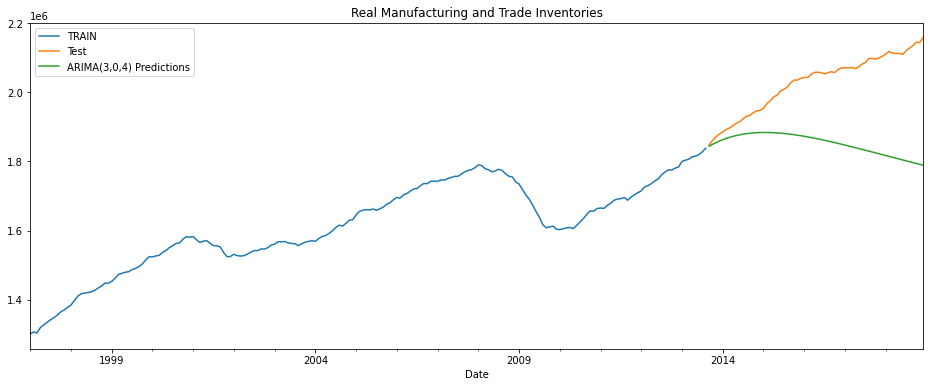

In [28]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='' 

train_data.plot(legend=True,label='TRAIN' ,figsize=(16,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(16,6),title=title)
predictions.plot(legend=True)
plt.show()

<AxesSubplot: xlabel='Date'>

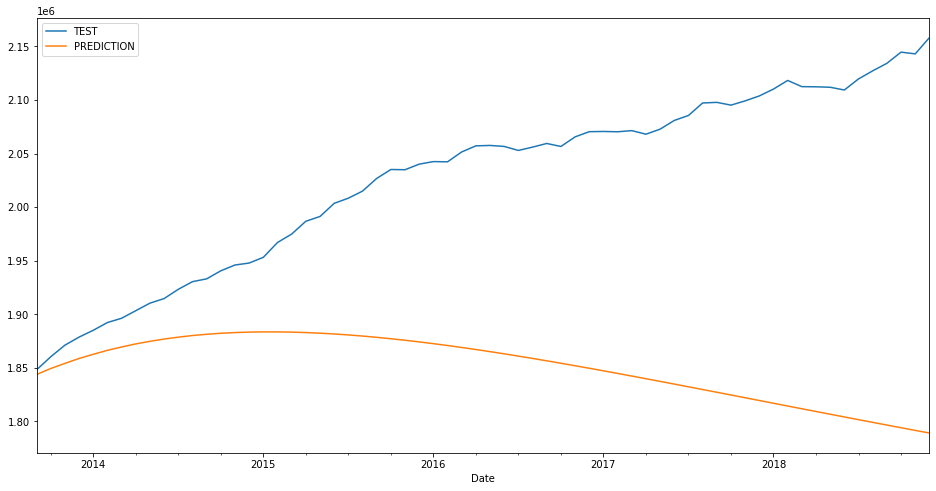

In [29]:
#train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data.plot(legend=True,label='TEST',figsize=(16,8))
predictions.plot(legend=True,label='PREDICTION',xlim=['2013-09-01','2018-12-01'])

### Evaluate the Model

In [30]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_data, predictions)
error.round(2)

41950838908.22

In [31]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_data, predictions)
error.round(2)

204819.04

### Retrain the model on the full data, and forecast the future

In [32]:
model = ARIMA(df2['Inventories'],order=(3,0,4))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(3,0,4) Forecast')

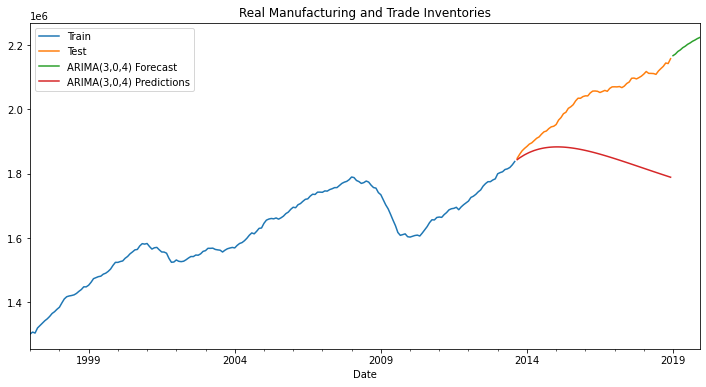

In [33]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='Period' 

train_data.plot(legend=True,label='Train',figsize=(12,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(12,6),title=title)
fcast.plot(legend=True)
predictions.plot(legend=True)
plt.show()